<a href="https://colab.research.google.com/github/BeamlakTamirat/DS/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders

In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path  = kagglehub.dataset_download('elikplim/car-evaluation-data-set')

In [ ]:
df = pd.read_csv(path + '/car_evaluation.csv', header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
df.shape

(1728, 7)

In [ ]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.columns = col_names
col_names


['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [ ]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
for col in col_names:
    print(df[col].value_counts())

buying
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
maint
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64
persons
2       576
4       576
more    576
Name: count, dtype: int64
lug_boot
small    576
med      576
big      576
Name: count, dtype: int64
safety
low     576
med     576
high    576
Name: count, dtype: int64
class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


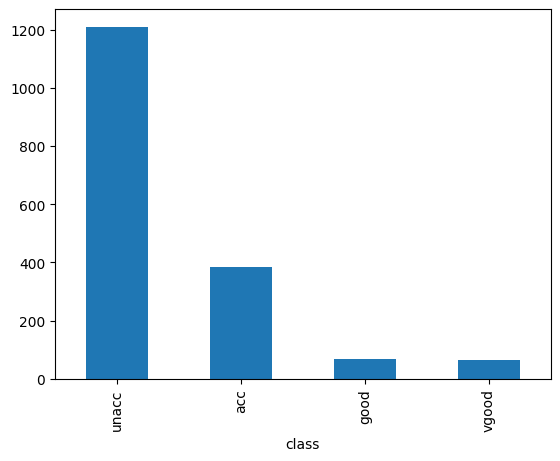

In [ ]:
df['class'].value_counts().plot(kind='bar');

## Encode

In [ ]:
import category_encoders as ce
# encode categorical variables with ordinal encoding
encoder = ce.OrdinalEncoder(cols=df.select_dtypes(include='object'))
df = encoder.fit_transform(df)

## Split

In [ ]:
X = df.drop(columns=['class'], axis=1)
y = df['class']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Over Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler()
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (3900, 6)


,buying,maint,doors,persons,lug_boot,safety
0,1,1,4,3,3,3
1,3,1,2,2,1,2
2,4,4,4,1,3,3
3,2,3,3,1,2,2
4,2,3,2,1,2,1


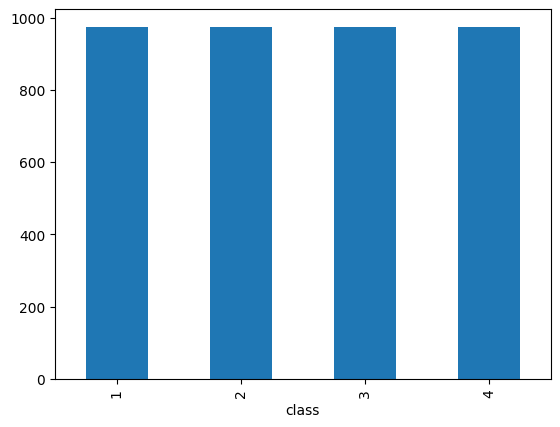

In [ ]:
y_train_over.value_counts().plot(kind='bar');

## Hyper Paramater Tuning and Cross Validation

In [ ]:
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

In [ ]:
import xgboost as xgb
clf = xgb.XGBClassifier(random_state=42)


In [ ]:
y_train_over.min()

In [ ]:
if y_train_over.min() == 1:
  y_train_over = y_train_over - 1

In [ ]:
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(clf, param_grid=params, cv=5, verbose=1, n_jobs=-1)
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:41:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             verbose=1)

In [ ]:
if y_test.min() == 1:
  y_test = y_test - 1

In [ ]:
# Evaluate
from sklearn.metrics import accuracy_score
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", model.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 1.0}
Test Accuracy: 0.9826589595375722


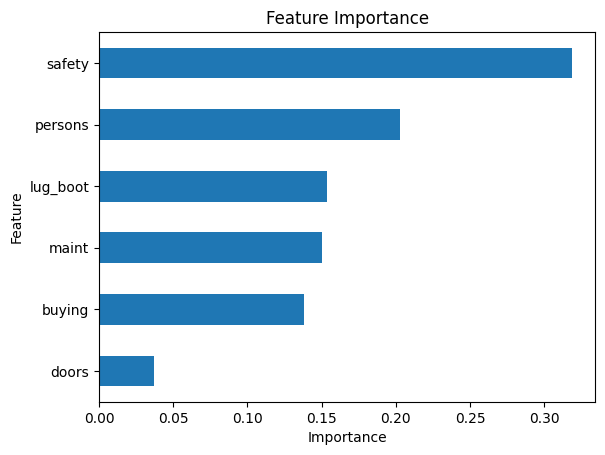

In [ ]:
features = X_train.columns
# Extract importances from model
importances = model.best_estimator_.feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)
# Plot 10 most important features

feat_imp.plot(kind='barh')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");